In [1]:
%run init_notebookspace.py
from settings import DATA_DIR

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\bayes_filter\data


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from src.pull_data import load_csv, get_yf_ticker_data, train_test_split
from src.hmm import get_CV_data

In [ ]:
start = '2015-01-01'
end = '2022-12-31'

In [ ]:
from src.pull_data import get_index_nlargest_composits, get_index_yf_tickers
from itertools import chain

sel_ind = 'CAC 40'
sel_ind_ticker = ['^FCHI']
sel_ind_composit_tickers, _, sel_ind_nlargest_tickers, success = get_index_nlargest_composits(sel_ind, n=5)
if success <= .8: st.write(f'Market cap was only available for {success*100: .1f} %  of composits')
df_prices = get_yf_ticker_data(sel_ind_nlargest_tickers, start, end)
df_prices = df_prices.join(get_yf_ticker_data(sel_ind_ticker, start, end, price_kind=['Open', 'High', 'Low', 'Volume', 'Adj Close']))
df_prices.columns = [item if '_Adj Close' not in item else item[:-10] for item in df_prices.columns]
# df_prices = get_yf_ticker_data([*chain(sel_ind_ticker, sel_ind_nlargest_tickers)], start, end)

x = df_prices[df_prices['^FCHI_Volume'] == 0].index 
df_prices.loc[x, '^FCHI_Volume'] = [1e-8] * 56

# get log return data
df_rets = np.log(df_prices / df_prices.shift(1)).dropna().copy()

In [97]:
# define binned data
# ser = train1.Adj_Close_rets.copy()
# intervals = {
#     0: [-1000000, ser.quantile(1/3)],
#     1: [ser.quantile(1/3), ser.quantile(2/3)],
#     2: [ser.quantile(2/3), 1000000]
# }

# plt.hist(ser, bins='fd', density=True);
# plt.vlines(intervals[1][0], 0, .025, color='red');
# plt.vlines(intervals[1][1], 0, .025, color='red');

# train2['Adj_Close_regimes'] = train2['Adj_Close_rets'].apply(lambda x: float(apply_intervals(x, intervals)))
# train2['Adj_Close_regimes_prev'] = train2['Adj_Close_regimes'].shift(1)
# train2.dropna(inplace=True)

In [98]:
# # state space
# T = train2.groupby(['Adj_Close_regimes', 'Adj_Close_regimes_prev'])['Adj_Close_regimes'].count().unstack()
# T = T.apply(lambda x: x / sum(x), axis=1)

# def _get_markov_edges(Q):
#     edges = {}
#     for col in Q.columns:
#         for idx in Q.index:
#             edges[(idx,col)] = Q.loc[idx,col]
#     return edges
# edges_wts = _get_markov_edges(T)
# print(edges_wts)

In [99]:
from src.utils import printProgBar
from random import randint
def get_CV_data(df_rets: np.array, df_prices: np.array, rets_cols: list, prices_cols: list, ind_ticker: str, n_largest_stocks: list, n_iterations: int, sample_size: tuple=(10, 30)) -> (np.array, list):
    quotes = []
    assert len(df_prices) == len(df_rets)

    for i in range(0, n_iterations):
        # printProgBar(i, n_iterations)

        # random sample len
        sample_len = randint(sample_size[0], sample_size[1])
        # random sample start
        sample_start = randint(0, len(df_rets) - sample_len)
        rets_subset = rets_data[sample_start: sample_start + sample_len]
        prices_subset = price_data[sample_start: sample_start + sample_len]
        
        # generate features
        # close_date
        # close_date = np.max(arr_subset[:, cols.index('date')])
        
        # volume_gap
        x = prices_subset[:, price_cols.index(f'{ind_ticker}_Volume')]
        vol_gap = np.diff(x) / x[1:]
        
        # daily_change
        d_change = ((prices_subset[:, prices_cols.index(ind_ticker)] - prices_subset[:, prices_cols.index(f'{ind_ticker}_Open')]) / prices_subset[:, prices_cols.index(f'{ind_ticker}_Open')])[1:]
        
        #fract_high
        frac_high = ((prices_subset[:, prices_cols.index(f'{ind_ticker}_High')] - prices_subset[:, prices_cols.index(f'{ind_ticker}_Open')]) / prices_subset[:, prices_cols.index(f'{ind_ticker}_Open')])[1:]
        
        # fract_low
        frac_low = ((prices_subset[:, prices_cols.index(f'{ind_ticker}_Low')] - prices_subset[:, prices_cols.index(f'{ind_ticker}_Open')]) / prices_subset[:, prices_cols.index(f'{ind_ticker}_Open')])[1:]
        
        # n largest stocks
        x = [n_largest_stocks.index(item) for item in n_largest_stocks]
        n_largest = [rets_subset[:, x[i]][1:] for i in x]
        # return rets_subset, prices_subset
        # n_largest = [rets_subset[:][i][1:] for i in [rets_cols.index(item) for item in n_largest_stocks]]
        # print(n_largest)
    
        # forecast_variable
        forecast = rets_subset[:, rets_cols.index(ind_ticker)][1:]

        # append
        out_len = len(rets_subset) - 1
        out = np.array([*chain([[i] * out_len, vol_gap, d_change, frac_high, frac_low, forecast], [item for item in n_largest])], dtype='object')
        quotes.append(out)
    
    # user defined, depending on 
    ret_cols = [*chain(['id', 'volume_gap', 'daily_change', 'fract_high', 'fract_low', 'forecast_variable'], n_largest_stocks)] 
    return quotes, ret_cols

In [100]:
%%time

# data = train2.copy()
rets_data = df_rets.values
price_data = df_prices.loc[df_rets.index].values
rets_cols = list(df_rets.columns)
price_cols = list(df_prices.columns)

quotes, cols = get_CV_data(rets_data, price_data, rets_cols, price_cols, sel_ind_ticker[0], n_largest_stocks=list(sel_ind_nlargest_tickers), n_iterations=5_000)

CPU times: total: 78.1 ms
Wall time: 175 ms


In [101]:
from sklearn.preprocessing import scale

In [102]:
%%time

arr = np.concatenate(quotes, axis=1).transpose()

ind = [cols.index(item) for item in ['daily_change', 'fract_high', 'fract_low', 'volume_gap', 'forecast_variable']]
arr = arr[:, ind]

arr = np.column_stack([scale(arr[:, i]) for i in range(arr.shape[1])])
X_train, y_train = arr[:, :-1], arr[:, -1]

CPU times: total: 0 ns
Wall time: 56.6 ms


C:\Users\LukasGrahl\Documents\GIT\bayes_filter\env_bayes_filter\lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


In [103]:
# %%time
# # old way
# df_quotes = pd.DataFrame(np.concatenate(quotes, axis=1), index=cols).transpose()
# cols = ['daily_change', 'fract_high', 'fract_low', 'volume_gap', 'forecast_variable']
# arr = df_quotes[cols].values
# arr = [arr[:, i] for i in range(0, len(cols))]
# arr = np.column_stack([scale(item) for item in arr])
# X_train, y_train = arr, arr[:, -1]


# # arr = df_test[cols].values
# # arr = [arr[:, i] for i in range(0, len(cols))]
# # arr = np.column_stack([scale(item) for item in arr])
# # X_test, y_test = arr[:, :-1], arr[:, -1]

In [104]:
from sklearn.mixture import GaussianMixture

In [176]:
# grid search bic
n = np.arange(1, 3)
bic = np.zeros(n.shape)
models = []
for i, j in enumerate(n):
    gmm = GaussianMixture(n_components=j, random_state=101)
    gmm.fit(X_train, y_train)
    bic[i] = gmm.bic(X_train)
    models.append(gmm)
    
best = np.where(bic==np.min(bic))[0][0]
best_no_regs = n[best]
print('\n', f'best model is no {best} with {n[best]} regimes')
best_mod = models[best]


 best model is no 1 with 2 regimes


In [75]:
%%time

mod = GaussianMixture(n_components=3, covariance_type='full', n_init=100, random_state=101) #n_init=100
mod.fit(X_train)
hidden_states = mod.predict(X_train)

KeyboardInterrupt: 

In [19]:
def print_gmm_res(gmm, X):
    print('\n')
    print('-' * 25)
    print(' '*5, "GMM Results", ' ' * 5)
    print('-'*25)
    print(f'means: \n{gmm.means_.ravel()}')
    print('-'*25)
    print(f'covars: \n{gmm.covariances_.ravel()}')
    print('-'*25)
    print(f'sqrt covars: \n{np.sqrt(gmm.covariances_.ravel())}')
    print('-'*25)
    print(f'aic: {gmm.aic(X): .5f}')
    print(f'bic: {gmm.bic(X): .4f}')
    print('-'*25, '\n')
    pass

def print_gmm_states(gmm):
    print('\n')
    print('-'*25)
    print(' '*5, "GMM STATES", ' ' * 5)
    for i in range(gmm.n_components):   
        print('-'*25)
        print(f"{i}th hidden state")
        print(f'mean: {mod.means_[i]}')
        print(f'var: {np.diag(mod.covariances_[i])}')
        print('-'*25, '\n')
        pass
        
print_gmm_res(mod, X_train)

# print(f'data derived mean: {forecast.mean(): .7f}')
# print(f'data derived std : {forecast.std(): .7f}')

print_gmm_states(mod)



-------------------------
      GMM Results      
-------------------------
means: 
[ 0.46759375  0.11738736  0.47897748  0.09714498 -0.21216097  1.00646955
 -1.20374726  0.174195   -0.60633285 -0.51057371 -0.28752824 -0.19977929]
-------------------------
covars: 
[ 0.32962585  0.43260298  0.0744272   0.04623962  0.43260298  0.67759473
  0.09758615  0.06558192  0.0744272   0.09758615  0.10496021  0.00696282
  0.04623962  0.06558192  0.00696282  0.33625427  3.60645132  2.06575572
  2.49943403 -0.27648261  2.06575572  3.01759604  1.21668785 -0.11217785
  2.49943403  1.21668785  3.38365101 -0.24588905 -0.27648261 -0.11217785
 -0.24588905  0.8724219   0.39082262  0.09494665  0.43209423 -0.24228185
  0.09494665  0.16205443  0.12438212 -0.03411893  0.43209423  0.12438212
  0.58653018 -0.30737028 -0.24228185 -0.03411893 -0.30737028  1.94181104]
-------------------------
sqrt covars: 
[0.57413051 0.65772561 0.27281349 0.215034   0.65772561 0.82316143
 0.31238782 0.25608967 0.27281349 0.3123

C:\Users\LukasGrahl\AppData\Local\Temp\ipykernel_23792\3845671414.py:10: RuntimeWarning: invalid value encountered in sqrt
  print(f'sqrt covars: \n{np.sqrt(gmm.covariances_.ravel())}')


In [105]:
def get_hmm(X_train, y_train, n_components: int, cov_type: str='full', n_int: int=100, random_state=101):
    mod = GaussianMixture(n_components=n_components, covariance_type=cov_type, n_init=n_int, random_state=random_state)
    mod.fit(X_train, y_train)
    hidden_states = mod.predict(X_train)
    return mod, hidden_states

def get_hidden_states(hidden_states, y_train):
    states = np.zeros((len(y_train), 2))
    states[:, 0] = hidden_states
    states[:, 1] = y_train
    states = pd.DataFrame(states, columns=['states', 'rets'])
    statesg = states.groupby('states').agg({'rets': ['mean', 'std', 
                                                    lambda x: np.mean(x) + 1.96 * np.std(x),
                                                    lambda x: np.mean(x) - 1.96 * np.std(x)]}).rename(columns={'<lambda_0>': 'conf_lower',
                                                                                                               '<lambda_1>': 'conf_upper'})
    statesg.columns = statesg.columns.get_level_values(1)
    return states, statesg


In [115]:
%%time

mod = GaussianMixture(n_components=3, covariance_type='full', n_init=100, random_state=101) #n_init=100
mod.fit(X_train, y_train)
hidden_states = mod.predict(X_train)

CPU times: total: 1min 56s
Wall time: 1min 33s


In [116]:
# print_gmm_res(mod, X_train)
# print_gmm_states(mod)

In [117]:
states = np.zeros((len(y_train), 2))
states[:, 0] = hidden_states
states[:, 1] = y_train
states = pd.DataFrame(states, columns=['states', 'rets'])

statesg = states.groupby('states').agg({'rets': ['mean', 'std', 
                                                lambda x: np.mean(x) + 1.96 * np.std(x),
                                                lambda x: np.mean(x) - 1.96 * np.std(x)]}).rename(columns={'<lambda_0>': 'conf_lower',
                                                                                                           '<lambda_1>': 'conf_upper'})
statesg.columns = statesg.columns.get_level_values(1)

In [118]:
statesg

mean       std  conf_lower  conf_upper
states                                            
0.0     0.084284  0.572758    1.206881   -1.038313
1.0    -0.598694  2.044190    3.406638   -4.604027
2.0    -0.164115  1.527695    2.830114   -3.158344

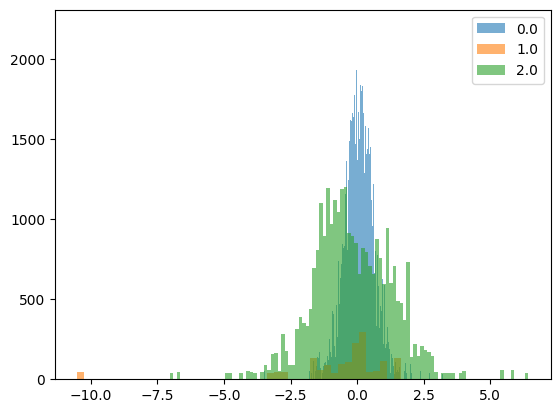

In [119]:
for i in set(states['states']):
    plt.hist(states[states['states'] == i]['rets'], bins='fd', alpha=.6, label=i)
plt.legend()

In [120]:
import plotly.express as px

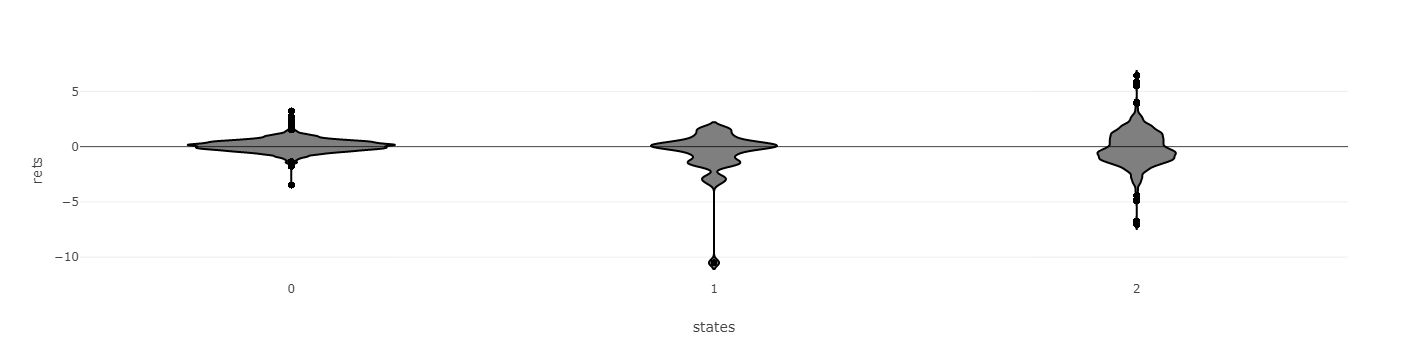

In [121]:
px.violin(states, x='states', y='rets')

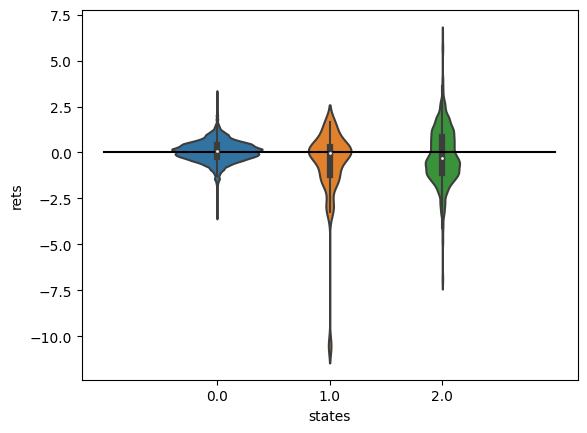

In [124]:
import seaborn as sns
sns.violinplot(states, x='states', y='rets')
plt.plot([-1, 0, 1, 2, 3], [0, 0, 0, 0, 0], color='black')

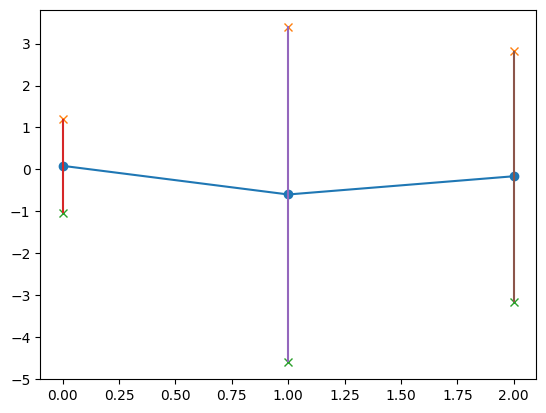

In [123]:
plt.plot(statesg.index, statesg['mean'], marker='o')
plt.plot(statesg.index, statesg['conf_lower'], marker='x', linewidth=0)
plt.plot(statesg.index, statesg['conf_upper'], marker='x', linewidth=0)
for i in range(0, len(statesg)):
    plt.errorbar(statesg.index[i], statesg['mean'][i], 1.96 * statesg['std'][i])

hmm library

In [39]:
from hmmlearn import hmm

In [40]:
df = get_yf_ticker_data(['^GSPC'], start, end, ['Adj Close', 'Open', 'High', 'Low', 'Volume'])
df.columns = [item[6:] for item in df.columns]
df = df.reset_index(names='date')

df["datetime"] = pd.to_datetime(df["date"])
df['Adj_Close_rets'] = df['Adj Close'].diff()
df.dropna(inplace=True)

df = df.iloc[:-251]

train1, train2, test = train_test_split(df, [.15, .6])

[*********************100%***********************]  1 of 1 completed


In [41]:
X = df[['Adj_Close_rets']].values

# Build the HMM model and fit to the gold price change data.
mod = hmm.GaussianHMM(n_components = 3, covariance_type = "diag", n_iter = 50, random_state = 42)
mod.fit(X)

# Predict the hidden states corresponding to observed X.
Z = mod.predict(X)
states = pd.unique(Z)

C:\Users\LukasGrahl\Documents\GIT\bayes_filter\env_bayes_filter\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [42]:
states

array([2, 0, 1], dtype=int64)

In [43]:
mod.startprob_

array([1.63299399e-35, 3.00962072e-17, 1.00000000e+00])

In [44]:
mod.transmat_

array([[3.15081720e-02, 9.68288862e-01, 2.02965955e-04],
       [8.25390710e-01, 1.30617243e-01, 4.39920467e-02],
       [3.08384036e-02, 2.49340433e-02, 9.44227553e-01]])

In [45]:
mod.means_

array([[ 0.52740862],
       [ 4.81045582],
       [-1.39685315]])

In [46]:
mod.covars_

array([[[ 128.81576892]],

       [[ 282.49435005]],

       [[2819.83968743]]])

In [87]:
def plot_hmm_states(df, price_col: str, ret_col: str, date_col: str):
    states = set(list(y_states))
    
    plt.figure(figsize = (15, 10))
    plt.subplot(2,1,1)
    
    for i in states:
        want = (y_states == i)
        # x = df[date_col].iloc[want]
        y = df[price_col].iloc[want]
        plt.plot(x, y, '.')
    plt.legend(states, fontsize=16)
    plt.grid(True)
    # plt.xlabel(date_col, fontsize=16)
    plt.subplot(2,1,2)
    for i in states:
        want = (Z == i)
        # x = df[data].iloc[want]
        y = df[rets_col].iloc[want]
        plt.plot(x, y, '.')
    plt.legend(states, fontsize=16)
    plt.grid(True)
    # plt.xlabel("datetime", fontsize=16)
    pass

In [88]:
df = pd.DataFrame(np.concatenate([X_train, y_train.reshape((len(y_train), 1)),
                             hidden_states.reshape((len(hidden_states), 1))], axis=1), 
             columns=[*chain(['volume_gap',
                             'daily_change',
                             'fract_high',
                             'fract_low'], ['returns'], ['state'])])

In [ ]:
plot_hmm_states(df, 'returns', 'state'

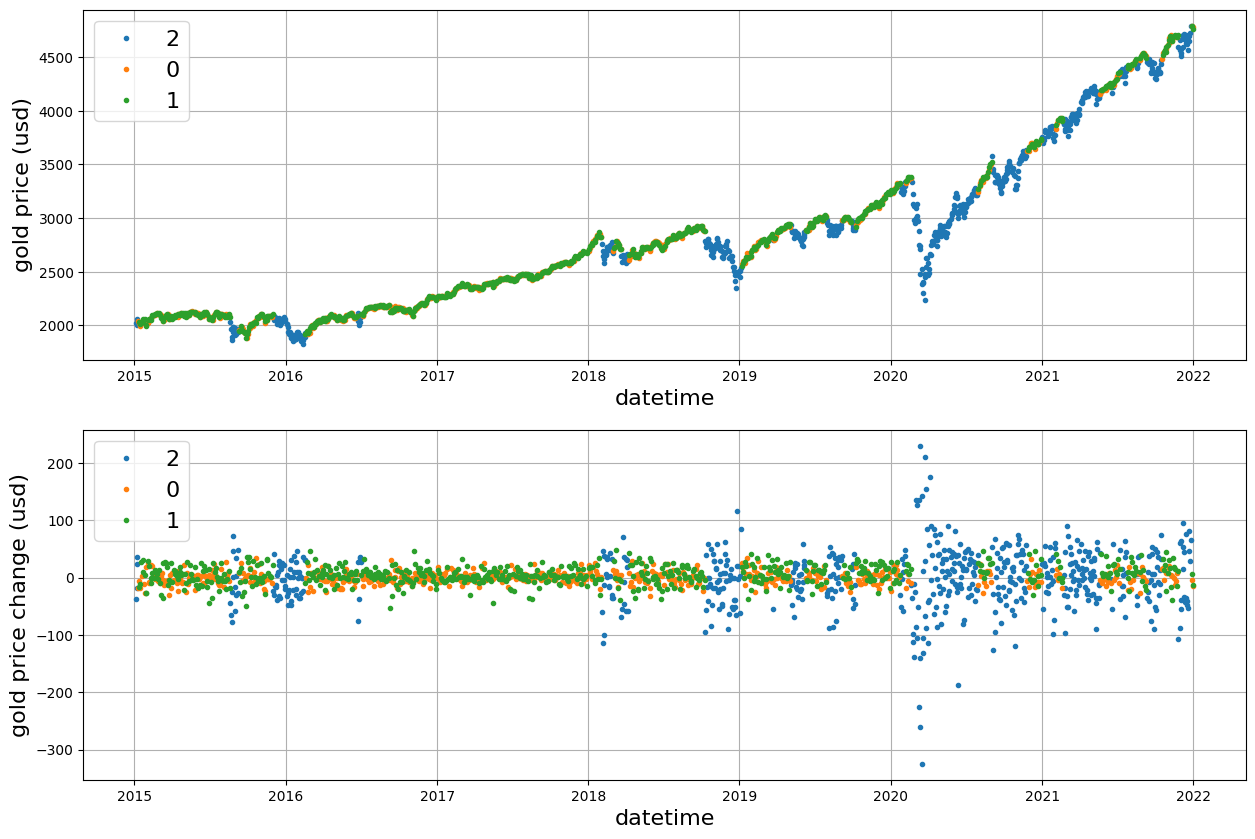